In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm
from scipy.special import softmax
from sklearn import metrics

In [2]:
DEPTH_MULTIPLIER_PREFIX = '0'
DEPTH_MULTIPLIER = 25
IMAGE_SIZE = 128
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE)
BATCH_SIZE = 100
NUM_EPOCHS = 20

## **Load model & get feature extraction layer**

In [3]:
model_name = 'mobilenet_v1_'+ DEPTH_MULTIPLIER_PREFIX + str(DEPTH_MULTIPLIER)+'_'+str(IMAGE_SIZE)+'_epochs_'+str(NUM_EPOCHS)
model_path = 'models\\' + model_name
model = tf.keras.models.load_model(model_path)

In [4]:
#init feature extractor layer
fel = model.layers[0]
print(fel)

## **Init paths**

In [5]:
OUTPUT_FOLDER_NAME = "outputs"
DATA_NAME = "CIFAR_10"
OOD_DATA_NAME = "svhn"

FEATURES_FOLDER = os.path.join(OUTPUT_FOLDER_NAME, "features")
FEATURES_DATA_FOLDER = os.path.join(FEATURES_FOLDER, DATA_NAME)
OOD_FEATURES_DATA_FOLDER = os.path.join(FEATURES_FOLDER, OOD_DATA_NAME)

DISTS_FOLDER = os.path.join(OUTPUT_FOLDER_NAME, "dists")
DISTS_DATA_FOLDER = os.path.join(DISTS_FOLDER, DATA_NAME)
OOD_DISTS_DATA_FOLDER = os.path.join(DISTS_FOLDER, OOD_DATA_NAME)

CLOSEST_CLASS_FOLDER = os.path.join(OUTPUT_FOLDER_NAME, "closest_classes")
CLOSEST_CLASS_DATA_FOLDER = os.path.join(CLOSEST_CLASS_FOLDER, DATA_NAME)
OOD_CLOSEST_CLASS_DATA_FOLDER = os.path.join(CLOSEST_CLASS_FOLDER, OOD_DATA_NAME)

PROBABILITIES_FOLDER = os.path.join(OUTPUT_FOLDER_NAME, "probabilities")
PROBABILITIES_DATA_FOLDER = os.path.join(PROBABILITIES_FOLDER, DATA_NAME)
OOD_PROBABILITIES_DATA_FOLDER = os.path.join(PROBABILITIES_FOLDER, OOD_DATA_NAME)

LABELS_FOLDER = os.path.join(OUTPUT_FOLDER_NAME, "labels")
LABELS_DATA_FOLDER = os.path.join(LABELS_FOLDER, DATA_NAME)

MEANS_FOLDER = os.path.join(OUTPUT_FOLDER_NAME, "means")
MEANS_DATA_FOLDER = os.path.join(MEANS_FOLDER, DATA_NAME)    

RADIUS_FOLDER = os.path.join(OUTPUT_FOLDER_NAME, "radius")
RADIUS_DATA_FOLDER = os.path.join(RADIUS_FOLDER, DATA_NAME)

SCORES_FOLDER = os.path.join(OUTPUT_FOLDER_NAME, "scores")
SCORES_DATA_FOLDER = os.path.join(SCORES_FOLDER, DATA_NAME)
OOD_SCORES_DATA_FOLDER = os.path.join(SCORES_FOLDER, OOD_DATA_NAME)

## **Load in-distribution data**

In [6]:
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
TOTAL_CLASSES = len(class_names)
print(TOTAL_CLASSES)

10


In [7]:
#load train features
CIFAR_10_train_features = [None] * 10
for i in range(TOTAL_CLASSES):
    save_name = "{0}_train_features_with_{1}_samples.npy".format(class_names[i], 5000)
    save_location = os.path.join(FEATURES_DATA_FOLDER, save_name)
    CIFAR_10_train_features[i]= np.load(save_location)
CIFAR_10_train_features = np.asarray(CIFAR_10_train_features)
print(CIFAR_10_train_features.shape)

(10, 5000, 256)


In [8]:
#load validation features
CIFAR_10_validation_features = [None] * 10
for i in range(TOTAL_CLASSES):
    save_name = "{0}_validation_features_with_{1}_samples.npy".format(class_names[i], 1000)
    save_location = os.path.join(FEATURES_DATA_FOLDER, save_name)
    CIFAR_10_validation_features[i]= np.load(save_location)
CIFAR_10_validation_features = np.asarray(CIFAR_10_validation_features)
print(CIFAR_10_validation_features.shape)

(10, 1000, 256)


In [9]:
#load class means
save_name = "CIFAR_10_class_means.npy"
save_location = os.path.join(MEANS_DATA_FOLDER, save_name)
class_means = np.load(save_location)
print(class_means.shape)

(10, 256)


In [10]:
#load class radii
save_name = "CIFAR_10_class_radii.npy"
save_location = os.path.join(RADIUS_DATA_FOLDER, save_name)
class_radii = np.load(save_location)
print(class_radii.shape)

(10,)


In [11]:
#load train distances & closest classes
CIFAR_10_train_distances = [None] * 10
CIFAR_10_train_closest_classes = [None] * 10
for i in range(TOTAL_CLASSES):
    #load distances
    save_name = "{0}_train_distances_with_{1}_samples.npy".format(class_names[i], 5000)
    save_location = os.path.join(DISTS_DATA_FOLDER, save_name)
    CIFAR_10_train_distances[i]= np.load(save_location)
    #load closest classes
    save_name = "{0}_train_closest_classes_with_{1}_samples.npy".format(class_names[i], 5000)
    save_location = os.path.join(CLOSEST_CLASS_DATA_FOLDER, save_name)
    CIFAR_10_train_closest_classes[i]= np.load(save_location)
CIFAR_10_train_distances = np.asarray(CIFAR_10_train_distances)
CIFAR_10_train_closest_classes = np.asarray(CIFAR_10_train_closest_classes)
print(CIFAR_10_train_distances.shape)
print(CIFAR_10_train_closest_classes.shape)

(10, 5000)
(10, 5000)


In [12]:
#load validation distances & closest classes
CIFAR_10_validation_distances = [None] * 10
CIFAR_10_validation_closest_classes = [None] * 10
for i in range(TOTAL_CLASSES):
    #load distances
    save_name = "{0}_validation_distances_with_{1}_samples.npy".format(class_names[i], 1000)
    save_location = os.path.join(DISTS_DATA_FOLDER, save_name)
    CIFAR_10_validation_distances[i]= np.load(save_location)
    #load closest classes
    save_name = "{0}_validation_closest_classes_with_{1}_samples.npy".format(class_names[i], 1000)
    save_location = os.path.join(CLOSEST_CLASS_DATA_FOLDER, save_name)
    CIFAR_10_validation_closest_classes[i]= np.load(save_location)
CIFAR_10_validation_distances = np.asarray(CIFAR_10_validation_distances)
CIFAR_10_validation_closest_classes = np.asarray(CIFAR_10_validation_closest_classes)
print(CIFAR_10_validation_distances.shape)
print(CIFAR_10_validation_closest_classes.shape)

(10, 1000)
(10, 1000)


In [13]:
# load train probabilites
CIFAR_10_train_probabilities = [None] * 10
CIFAR_10_train_scaled_probabilities = [None] * 10
for i in range(TOTAL_CLASSES):
    #load probabilites
    save_name = "{0}_train_probabilities_with_{1}_samples.npy".format(class_names[i], 5000)
    save_location =  os.path.join(PROBABILITIES_DATA_FOLDER, save_name)
    CIFAR_10_train_probabilities[i]= np.load(save_location)
    #load scaled probabilites
    save_name = "{0}_train_scaled_probabilities_with_{1}_samples.npy".format(class_names[i], 5000)
    save_location =  os.path.join(PROBABILITIES_DATA_FOLDER, save_name)
    CIFAR_10_train_scaled_probabilities[i]= np.load(save_location)
CIFAR_10_train_probabilities = np.asarray(CIFAR_10_train_probabilities)
CIFAR_10_train_scaled_probabilities = np.asarray(CIFAR_10_train_scaled_probabilities)
print(CIFAR_10_train_probabilities.shape)
print(CIFAR_10_train_scaled_probabilities.shape)

(10, 5000)
(10, 5000)


In [14]:
# load validation probabilites
CIFAR_10_validation_probabilities = [None] * 10
CIFAR_10_validation_scaled_probabilities = [None] * 10
for i in range(TOTAL_CLASSES):
    #load probabilites
    save_name = "{0}_validation_probabilities_with_{1}_samples.npy".format(class_names[i], 1000)
    save_location =  os.path.join(PROBABILITIES_DATA_FOLDER, save_name)
    CIFAR_10_validation_probabilities[i]= np.load(save_location)
    #load scaled probabilites
    save_name = "{0}_validation_scaled_probabilities_with_{1}_samples.npy".format(class_names[i], 1000)
    save_location =  os.path.join(PROBABILITIES_DATA_FOLDER, save_name)
    CIFAR_10_validation_scaled_probabilities[i]= np.load(save_location)
CIFAR_10_validation_probabilities = np.asarray(CIFAR_10_validation_probabilities)
CIFAR_10_validation_scaled_probabilities = np.asarray(CIFAR_10_validation_scaled_probabilities)
print(CIFAR_10_validation_probabilities.shape)
print(CIFAR_10_validation_scaled_probabilities.shape)

(10, 1000)
(10, 1000)


In [15]:
#load validation scores
save_name = "CIFAR_10_validation_scores.npy"
save_location =  os.path.join(SCORES_DATA_FOLDER, save_name)
CIFAR_10_validation_scores = np.load(save_location)
print(CIFAR_10_validation_scores.shape)

(10000,)


## **Load out-distribution data**

In [16]:
#load svhn features
save_name = "{0}_features_with_{1}_samples.npy".format(OOD_DATA_NAME, 13068)
save_location =  os.path.join(OOD_FEATURES_DATA_FOLDER, save_name)
svhn_features = np.load(save_location)
print(svhn_features.shape)

(13068, 256)


In [17]:
#load svhn distances
save_name = "{0}_distances_with_{1}_samples.npy".format(OOD_DATA_NAME, 13068)
save_location =  os.path.join(OOD_DISTS_DATA_FOLDER, save_name)
svhn_distances = np.load(save_location)
print(svhn_distances.shape)

(13068,)


In [18]:
#load svhn closest classes
save_name = "{0}_closest_classes_with_{1}_samples.npy".format(OOD_DATA_NAME, 13068)
save_location =  os.path.join(OOD_CLOSEST_CLASS_DATA_FOLDER, save_name)
svhn_closest_classes = np.load(save_location)
print(svhn_closest_classes.shape)

(13068,)


In [19]:
#load svhn probabilities
save_name = "{0}_probabilities_with_{1}_samples.npy".format(OOD_DATA_NAME, 13068)
save_location =  os.path.join(OOD_PROBABILITIES_DATA_FOLDER, save_name)
svhn_probabilities = np.load(save_location)
save_name = "{0}_scaled_probabilities_with_{1}_samples.npy".format(OOD_DATA_NAME, 13068)
save_location =  os.path.join(OOD_PROBABILITIES_DATA_FOLDER, save_name)
svhn_scaled_probabilities = np.load(save_location)
print(svhn_probabilities.shape)
print(svhn_scaled_probabilities.shape)

(13068,)
(13068,)


In [20]:
#load svhn scores
save_name = "{0}_scores_with_{1}_samples.npy".format(OOD_DATA_NAME, 13068)
save_location =  os.path.join(OOD_SCORES_DATA_FOLDER, save_name)
svhn_scores = np.load(save_location)
print(svhn_scores.shape)

(13068,)


## **Calculate TNR at 95% TPR**

In [21]:
#sort scores
CIFAR_10_validation_scores_sorted = sorted(CIFAR_10_validation_scores)
svhn_scores_sorted = sorted(svhn_scores)

In [22]:
threshold = CIFAR_10_validation_scores_sorted[9500]
print(threshold)

0.6082498549571127


In [23]:
out_of_bound_scores = [a for a in svhn_scores_sorted if a>threshold]
TOTAL_OUT_OF_BOUND_SCORES = len(out_of_bound_scores)
TOTAL_IN_BOUND_SCORES = 13068 - TOTAL_OUT_OF_BOUND_SCORES
print("Total out-of-bound scores - " + str(TOTAL_OUT_OF_BOUND_SCORES))
print("Total in-bound scores - " + str(TOTAL_IN_BOUND_SCORES))
print("TNR at 95% TPR - {0}%".format(TOTAL_OUT_OF_BOUND_SCORES*100/len(svhn_scores_sorted)))

Total out-of-bound scores - 12585
Total in-bound scores - 483
TNR at 95% TPR - 96.30394857667585%


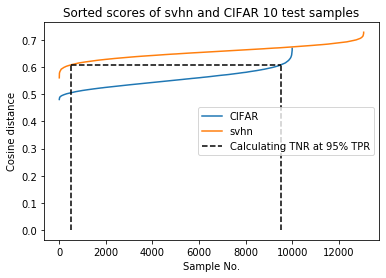

<Figure size 432x288 with 0 Axes>

In [24]:
plt.plot(CIFAR_10_validation_scores_sorted)
plt.plot(svhn_scores_sorted)

x_coordinates = [9500, 9500]
y_coordinates = [0, threshold]
plt.plot(x_coordinates, y_coordinates, 'k--')

x_coordinates = [TOTAL_IN_BOUND_SCORES, 9500]
y_coordinates = [threshold, threshold]
plt.plot(x_coordinates, y_coordinates, 'k--')

x_coordinates = [TOTAL_IN_BOUND_SCORES, TOTAL_IN_BOUND_SCORES]
y_coordinates = [0, threshold]
plt.plot(x_coordinates, y_coordinates, 'k--')

plt.title("Sorted scores of svhn and CIFAR 10 test samples")
plt.xlabel("Sample No.")
plt.ylabel("Cosine distance")
plt.legend(["CIFAR", "svhn", "Calculating TNR at 95% TPR"])

plt.show()
plt.draw()

## **Calculate Detection Accuracy**

In [25]:
y_pred = []
y_true = []
for i in range(len(CIFAR_10_validation_scores)):
    y_true.append(0)
    class_idx = int(i/1000)
    if(CIFAR_10_validation_scores[i]>class_radii[class_idx]):
        y_pred.append(1)
    else:
        y_pred.append(0)

for i in range(len(svhn_scores)):
    y_true.append(1)
    class_idx = int(i/1000)
    if(svhn_scores[i]>class_radii[svhn_closest_classes[i]]):
        y_pred.append(1)
    else:
        y_pred.append(0)

In [26]:
metrics.accuracy_score(y_true, y_pred)

0.954352349575169

## **Calculate AUPR score**

In [27]:
precision, recall, thresholds = metrics.precision_recall_curve(y_true, np.concatenate((CIFAR_10_validation_scores, svhn_scores)), pos_label=1)

No handles with labels found to put in legend.


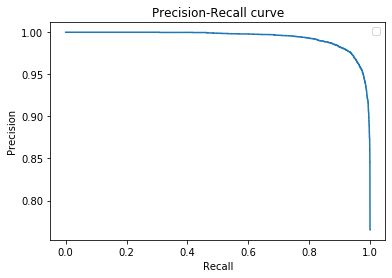

In [28]:
from matplotlib import pyplot
# plot model roc curve
pyplot.plot(recall, precision)
plt.title("Precision-Recall curve")
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [29]:
metrics.auc(recall, precision)

0.9938998233907559